In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("./USA_Hourly_PC.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index )

In [3]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [4]:
def features_generation(df):
    df = df.copy()
    #df['hour'] = df.index.hour 
    #df['dayofweek'] = df.index.dayofweek
    #df['month'] = df.index.month
    #df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    return df

In [5]:
df_new = features_generation(df)
df_new.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


<AxesSubplot:title={'center':'Hourly Power Consumption in USA'}, xlabel='Datetime'>

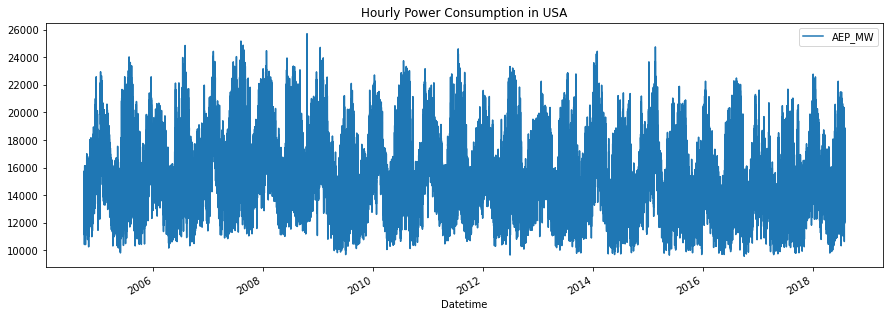

In [6]:
df.plot(figsize=(15,5),title="Hourly Power Consumption in USA")

<AxesSubplot:xlabel='Datetime'>

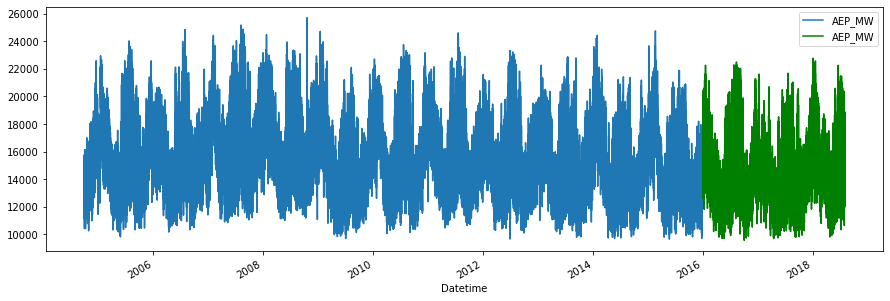

In [7]:
x_train = df.loc[df.index<'01-01-2016']
x_test = df.loc[df.index>='01-01-2016']
fig,ax = plt.subplots(figsize=(15,5))
x_train.plot(ax=ax,label='Training Set')
x_test.plot(ax=ax,label='Testing Set',color='g')

In [8]:
train = features_generation(x_train)
test = features_generation(x_test)

In [9]:
train

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2015-01-01 20:00:00,16586.0
2015-01-01 21:00:00,16312.0
2015-01-01 22:00:00,15859.0


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

In [124]:
# x_train = train.drop(['AEP_MW'],axis=1).values.reshape((len(train), 3))
# y_train = train['AEP_MW'].values.reshape((len(train), 1))

# scaler_train = MinMaxScaler(feature_range=(0, 1))
# scaler_label = MinMaxScaler(feature_range=(0, 1))
# x_train_scaled = scaler_train.fit_transform(x_train)
# y_train_scaled = scaler_label.fit_transform(y_train)
# train_scaled = np.hstack((x_train_scaled, y_train_scaled))

# train_scaled.shape

(98593, 4)

In [14]:
train_scaled

array([[0.23800911],
       [0.19977546],
       [0.18181251],
       ...,
       [0.38651531],
       [0.34510073],
       [0.31559908]])

In [15]:
def to_supervised(train, n_input, n_out):
	X, y = [], []
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(train)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(train):
			x_input = train[in_start:in_end]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(train[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)


In [16]:
x_train, y_train = to_supervised(train_scaled,60,1)
print(x_train.shape), print(y_train.shape)

(98532, 60, 1)
(98532, 1)


(None, None)

In [26]:
test_scaled = scaler.transform(test)

In [18]:
# x_test = test.drop(['AEP_MW'],axis=1).values.reshape((len(test), 3))
# y_test = test['AEP_MW'].values.reshape((len(test), 1))

# x_test_scaled = scaler_train.transform(x_test)
# y_test_scaled = scaler_label.transform(y_test)
# test_scaled = np.hstack((x_test_scaled, y_test_scaled))

# test_scaled.shape

In [27]:
x_test, y_test = to_supervised(test_scaled,60,1)
print(x_test.shape), print(y_test.shape)

(22619, 60, 1)
(22619, 1)


(None, None)

In [29]:
x_test

array([[[0.2964031 ],
        [0.40188192],
        [0.37995143],
        ...,
        [0.4329185 ],
        [0.43868569],
        [0.44786766]],

       [[0.40188192],
        [0.37995143],
        [0.37433601],
        ...,
        [0.43868569],
        [0.44786766],
        [0.44126575]],

       [[0.37995143],
        [0.37433601],
        [0.38017909],
        ...,
        [0.44786766],
        [0.44126575],
        [0.43086963]],

       ...,

       [[0.98975565],
        [0.96152679],
        [0.92381241],
        ...,
        [0.81180756],
        [0.86082865],
        [0.87327364]],

       [[0.96152679],
        [0.92381241],
        [0.86219457],
        ...,
        [0.86082865],
        [0.87327364],
        [0.86644407]],

       [[0.92381241],
        [0.86219457],
        [0.80626802],
        ...,
        [0.87327364],
        [0.86644407],
        [0.85286083]]])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout
import tensorflow as tf

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(60,1)))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.fit(x_train,y_train,epochs=5,batch_size=32,verbose=1)

Epoch 1/5
3080/3080 [==============================] - 235s 73ms/step - loss: 0.0043
Epoch 2/5
3080/3080 [==============================] - 185s 60ms/step - loss: 0.0012
Epoch 3/5
3080/3080 [==============================] - 184s 60ms/step - loss: 9.8267e-04
Epoch 4/5
3080/3080 [==============================] - 182s 59ms/step - loss: 9.0878e-04
Epoch 5/5
3080/3080 [==============================] - 183s 59ms/step - loss: 8.4265e-04


In [30]:
y_test_predict=model.predict(x_test)


707/707 [==============================] - 12s 17ms/step


In [31]:
y_test_predict.shape

(22619, 1)

In [32]:
y_test_predict

array([[0.45065236],
       [0.43685764],
       [0.4280344 ],
       ...,
       [0.8691342 ],
       [0.85385346],
       [0.8258708 ]], dtype=float32)

In [33]:
y_test_predict=scaler.inverse_transform(y_test_predict)
y_test_predict

array([[15519.696],
       [15337.91 ],
       [15221.638],
       ...,
       [21034.45 ],
       [20833.08 ],
       [20464.326]], dtype=float32)

In [34]:
y_test_predict.shape

(22619, 1)

In [35]:
test.shape

(22680, 1)

In [36]:
test_60 =  df[-22620:-1]

In [37]:
test_60.shape

(22619, 1)

In [38]:
test_60['prediction'] = y_test_predict

C:\Users\Pritesh Borad\AppData\Local\Temp\ipykernel_6700\579486569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_60['prediction'] = y_test_predict


In [39]:
test_60

,AEP_MW,prediction
Datetime,,
2016-12-29 12:00:00,15396.0,15519.696289
2016-12-29 13:00:00,15259.0,15337.910156
2016-12-29 14:00:00,15116.0,15221.637695
2016-12-29 15:00:00,14825.0,15165.667969
2016-12-29 16:00:00,14869.0,14986.689453
...,...,...
2018-01-01 19:00:00,20925.0,21010.068359
2018-01-01 20:00:00,21089.0,21069.628906
2018-01-01 21:00:00,20999.0,21034.449219


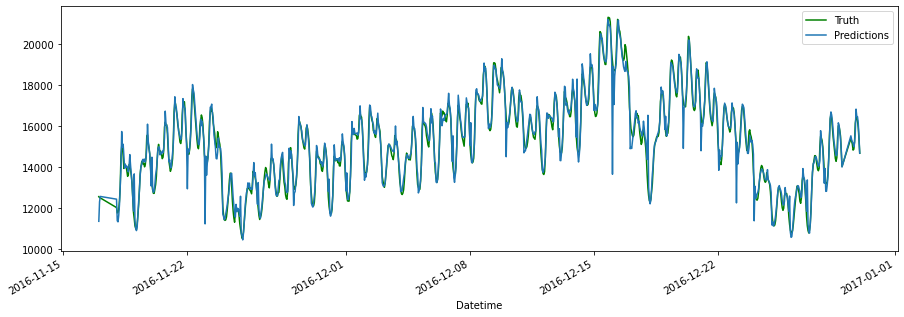

In [40]:
fig,ax = plt.subplots(figsize=(15,5))
test_60[0:1000]['AEP_MW'].plot(ax=ax,color='g')
test_60[0:1000]['prediction'].plot(ax=ax)
plt.legend(['Truth','Predictions'])
plt.show()